In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import multinomial, mode
from scipy import stats
from scipy.linalg.blas import dtrmm
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn.metrics import roc_auc_score, accuracy_score

import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import rc, font_manager
from matplotlib import rcParams
#from matplotlib2tikz import save as tikz_save

from importlib import reload
#import random
#random.seed(100)

import tensorflow as tf
from scipy.io import loadmat, savemat
from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.decomposition import PCA

In [ ]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook

def bin_Y(Y):
  lb = LabelBinarizer()
  lb.fit(np.unique(Y))
  N = Y.shape[0] 
  K = len(np.unique(Y))
  R = Y.shape[1]
  Ynew = np.zeros([N,K,R])

  for i in range(N):
    y_b = lb.transform(Y[i])

    if K == 2:
      y_b = np.concatenate((1-y_b.astype(bool), y_b), axis = 1) 
      
    Ynew[i,:,:] = y_b.T

  return Ynew

from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import StratifiedShuffleSplit

def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler


def scheduler2(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.01)


class NN_log(BaseEstimator, TransformerMixin):
  def __init__(self, K, P, w_init='PCA', epochs=30, batch_size=64,learning_rate=1e-3,optimizer='RMS',
               validation_split=0.3, verbose=1, ratio=1.2, scale=0.1, seed=None, ratio_lin=0.75,
               l1=0.01, l2=0.01, RBFout=100):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.ratio = ratio
        self.K = K
        self.P = P
        self.scale = scale
        self.l1 = l1
        self.l2 = l2
        self.w_init = w_init
        self.seed = seed
        self.RBFout = RBFout
        self.ratio_lin = ratio_lin

        
  def fit(self, X, y):
    #lb = LabelBinarizer()
    #lb.fit(X[:,-1])
    #N = X.shape[0]
    #y = np.zeros([N, self.K, self.R])
    #for i in range(N):
    #  y[i,:,:] = binarize(X[i,self.P:],lb).T

    Xt = X
    if self.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    elif self.optimizer == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
    elif self.optimizer == "RMS":
        opt = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate)
    else:
        opt=self.optimizer

    
    ###acomodar arquitectura de red###### 
    tf.keras.backend.clear_session()

    inputA = tf.keras.layers.Input(shape=(Xt.shape[1]), name='entradaA')

    Q1 = self.K ## num clases
    Q3 = int(self.ratio_lin*self.P)

    initializer = tf.keras.initializers.GlorotNormal(seed=self.seed)

    if self.w_init == 'PCA':
      pca = PCA().fit(Xt).components_
      initializer1 = tf.keras.initializers.Constant(value=pca[:Q3,:].T)
    else:
      initializer1 = initializer

    hW1 = tf.keras.layers.Dense(5,activation='exponential',name='W',  bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1,l2=self.l2))(inputA)

    hW1_1 = tf.keras.layers.Dense(self.RBFout,activation='tanh',name='W2',  bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1,l2=self.l2))(hW1)            
           
    
    #hW1_1 = tf.keras.layers.experimental.RandomFourierFeatures(output_dim=self.RBFout, name='RBF', kernel_initializer='gaussian', scale=self.scale)(hW1)
    
    hW = tf.keras.layers.Dense(Q1,activation='softmax',name='Yhat',  bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1,l2=self.l2))(hW1_1)

    self.model = tf.keras.Model(inputs=inputA, outputs=hW)
    self.model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                       optimizer=opt) #f1, precision, recall, crossentropy

    callback1 = tf.keras.callbacks.TerminateOnNaN()
    callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = self.ratio))
    #callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
    callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                                 patience=15, verbose=0, mode="auto",
                                                 baseline=None, restore_best_weights=True)

    
    self.history = self.model.fit(x = Xt, y = y,
                        epochs=self.epochs,batch_size=self.batch_size,
                        validation_split=self.validation_split, 
                        callbacks = [callback1, callback2],# callback3], 
                        verbose = self.verbose)
    
  def predict(self, X, *_):
    pred = self.model.predict(X)
    return np.argmax(pred, axis=1)
  
  def predict_proba(self, X, *_):
    pred = self.model.predict(X)
    return pred

  def plot_history_loss(self):
      plt.plot(self.history.history['loss'],label='loss')
      #plt.plot(self.history.history['val_loss'],label='val_loss')
      plt.legend()
      return
  
  def score(self, X, t):
    accuracy = np.mean(self.predict(X)==t.T)

    try:
      auc = roc_auc_score(ook(t), self.predict_proba(X))
    except:
      auc = 0.5
    
    dist = accuracy + auc

    return dist

## Some useful functions

In [ ]:
def one_of_K(y, K):
    Yhat = np.ones((y.shape[0], K))
    for k in range(K):
        Yhat[:,k,None] = (y==k+1).astype(np.int)
    return Yhat

#Defining the Sigmoid function and Softmax function
def Sigmoid(f_r):
    lam_r = 1/(1 + np.exp(-f_r))
    return lam_r

def Softmax(A):
    num = np.exp(A)
    den = np.sum(num, 1)
    den = den[:,np.newaxis]
    zeta_k = num/den
    return zeta_k

def MAjVot(Y, K):
    N,R = Y.shape
    Yhat = np.zeros((N,1))
    for n in range(N):
        votes = np.zeros((K,1))
        for r in range(R):
            for k in range(K):
                if Y[n,r] == k+1:
                    votes[k] = votes[k]+1
        Yhat[n] = np.argmax(votes) + 1
    return Yhat
    

## 1. Multi-class classification problem definition 

We assume a 1D multi-class classification problem, where input features are given as $x \in [0, 1]$ and the outputs are generated as follows

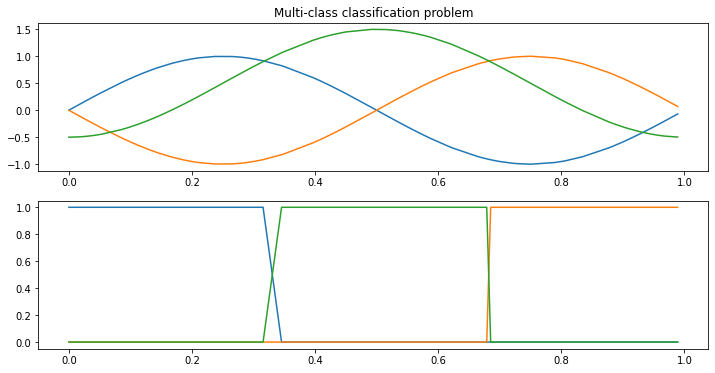

In [ ]:
N = 100

np.random.seed(1)
X = np.random.rand(N,1)

t1 = (np.sin(2*np.pi*X)).reshape(N,1)
t2 = (-np.sin(2*np.pi*X)).reshape(N,1)
t3 = (-np.sin(2*np.pi*(X+0.25))+0.5).reshape(N,1)
t = np.concatenate((t1, t2, t3), axis=1)

idx = np.argsort(X, axis=0).flatten()
X = X[idx]
t = t[idx,:]
y = np.array(np.argmax(t, 1).reshape(-1,1), dtype=float)+1
K = len(np.unique(y))

# The true labels in codification 1-of-K
Yhat = one_of_K(y, K)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(X, t)
plt.title('Multi-class classification problem')
plt.subplot(2,1,2)
plt.plot(X, Yhat)
plt.show()

To define the training set, we randomly obtain $N=100$ samples from the interval $[0, 1]$. Conversely, for the test set, we sample uniformly $200$ points from $[0, 1]$

In [ ]:
seed = 0
np.random.seed(seed)
N = 100
Ntest = 200

Xtrain = X
Xtrain = Xtrain.reshape((N,1))
ytrain = y

N_train = Xtrain.shape[0]
P = Xtrain.shape[1]

Xtest = np.linspace(0, 1, Ntest).reshape((Ntest,1))
t1 = (np.sin(2*np.pi*Xtest)).reshape(Ntest,1)
t2 = (-np.sin(2*np.pi*Xtest)).reshape(Ntest,1)
t3 = (-np.sin(2*np.pi*(Xtest+0.25))+0.5).reshape(Ntest,1)
ttest = np.concatenate((t1, t2, t3), axis=1)
ytest = np.array(np.argmax(ttest, 1).reshape(-1,1), dtype=float)+1

In [ ]:
mdl = NN_log(K, P, w_init='PCA', epochs=100, batch_size=N_train,learning_rate=0.1,optimizer='RMS',
             validation_split=0, verbose=1, ratio=1, scale=0.1, seed=1, ratio_lin=1,
             l1=0.01, l2=0.01, RBFout=20)

In [ ]:
mdl.fit(Xtrain, one_of_K(ytrain, K))

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 1.5977
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 3.7753
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 3.6644
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 1.7979
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 2.6704
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 1.9811
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 1.4620
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 1.4132
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 1.4472
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 1.5597
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 1.4597
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 1.4230
Epoch 13/100
1/1 [==============================] - 0s 3ms/st

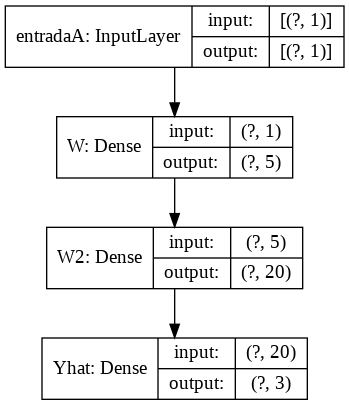

In [ ]:
tf.keras.utils.plot_model(mdl.model, show_shapes=True)

In [ ]:
mdl.predict(Xtest)+1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [ ]:
ytest.T==mdl.predict(Xtest)+1

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [ ]:
ytest.T

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2.]])